In [36]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
import pickle

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate, KFold

from rogi import RoughnessIndex, MODI

from tdc.single_pred import ADME, Tox
from tdc.utils import retrieve_label_name_list

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib
import seaborn as sns
sns.set(style='ticks')

In [22]:
def compute_rdkit_descriptors(smi):
    m = Chem.MolFromSmiles(smi)
    descriptor_names = [desc[0] for desc in Descriptors.descList]
    descriptor_funcs = [desc[1] for desc in Descriptors.descList]
    descriptors = [desc(m) for desc in descriptor_funcs]
    return descriptors


def smiles_to_descriptors_df(smiles, descriptors=None):
    Xdict = {}
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    for desc in Descriptors.descList:
        name = desc[0]
        f = desc[1]

        if descriptors is not None and name in descriptors:
            Xdict[name] = [f(m) for m in mols]
    return pd.DataFrame(Xdict)
        

def plot_scatter(ax, x, y, title='', marker='X', s=100, 
                 fit=False, fit_outline=True, fit_lw=1, fit_zorder=0,
                 color='b', edgecolor='k', linewidth=0.5, alpha_face=1, alpha_edge=1,
                 annotate=True, text_color='k', x_text=0.55, y_text=0.9, fontsize=10,
                 zorder_scatter=5, label=''):

    if fit:
        coef = np.polyfit(x, y, 1)
        poly1d_fn = np.poly1d( coef)
        if fit_outline:
            ax.plot([min(x), max(x)], [poly1d_fn(min(x)), poly1d_fn(max(x))], linestyle='-', color='white', zorder=fit_zorder-1, linewidth=fit_lw+1)
        ax.plot([min(x), max(x)], [poly1d_fn(min(x)), poly1d_fn(max(x))], linestyle='--', color=color, zorder=fit_zorder, linewidth=fit_lw)

    # face
    ax.scatter(x, y, marker=marker, s=s, color=color, edgecolor='none', linewidth=0, alpha=alpha_face, zorder=zorder_scatter, label=label)
    # edges
    ax.scatter(x, y, marker=marker, s=s, facecolor="none", edgecolor=edgecolor, linewidth=linewidth, alpha=alpha_edge, zorder=zorder_scatter)

    ax.set_title(title)

    if annotate:
        pears = pearsonr(x, y)[0]
        _ = ax.annotate(f'$r = {pears:.2f}$', xy=(x_text, y_text), xycoords='axes fraction', ha='right', color=text_color, fontsize=fontsize,
                        zorder=10, path_effects=[pe.withStroke(linewidth=2, foreground="white")])


In [3]:
# ---------------------------
# TDC classification datasets
# ---------------------------
adme_props = [('HIA_Hou', None), 
              ('Pgp_Broccatelli', None), 
              ('Bioavailability_Ma', None), 
              ('BBB_Martins', None), 
              ('CYP2C19_Veith', None), 
              ('CYP2D6_Veith', None), 
              ('CYP3A4_Veith', None), 
              ('CYP1A2_Veith', None), 
              ('CYP2C9_Veith', None), 
              ('CYP2C9_Substrate_CarbonMangels', None), 
              ('CYP2D6_Substrate_CarbonMangels', None), 
              ('CYP3A4_Substrate_CarbonMangels', None)]

# pick 12 at random from ToxCast to be appended to Tox list
np.random.seed(42)
toxcast_list = np.random.choice(retrieve_label_name_list('Toxcast'), size=19, replace=False)

tox_props = ([('hERG', None), 
             ('AMES', None), 
             ('DILI', None) ,
             ('Skin Reaction', None), 
             ('Carcinogens_Lagunin', None), 
             ('ClinTox', None),
             ('herg_central', 'hERG_inhib')] + 
             # 12 tasks from Tox21
             [('Tox21', l) for l in retrieve_label_name_list('Tox21')] +
             # 19 tasks from ToxCast
             [('Toxcast', l) for l in toxcast_list])

# combine
props = []
props.extend(adme_props)
props.extend(tox_props)

print(f"--> {len(props)} classificatoin tasks")

# def func to get TDC dataset
def get_tdc_dataset(name, label_name):
        
    if (name, label_name) in adme_props:
        df = ADME(name=name, label_name=label_name).get_data()
    elif (name, label_name) in tox_props:
        df = Tox(name=name, label_name=label_name).get_data()
    else:
        raise ValueError(f'Cannot understand {name}, {label_name}')
        
    # subsample
    if len(df) > 10000:
        df = df.sample(n=10000, random_state=42)
    
    return df

# -----------------
# ML models to use
# -----------------
models = {'KNN': KNeighborsClassifier(), # neirest neighbor 
          'LR': LogisticRegression(random_state=42), # linear model
          'RF': RandomForestClassifier(n_estimators=50, n_jobs=12, random_state=42), # tree-based
          'SVC': SVC(random_state=42), # kernel method
          'MLP': MLPClassifier(random_state=42) # neural network
          }

# --------------------------------------------
# select a bunch of commonly-used descriptors
# --------------------------------------------
desc_names = ['MolWt', 'FractionCSP3', 'NumHAcceptors', 'NumHDonors', 'NOCount', 'NHOHCount',
              'NumAliphaticRings', 'NumAliphaticHeterocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 
              'NumRotatableBonds', 'TPSA', 'qed', 'MolLogP']

# -----------------------------
# Dict use to store all results
# -----------------------------
RESULTS = {}
RESULTS['TDC'] = {}

--> 50 classificatoin tasks


### TDC + Fingerprints

In [34]:
RESULTS['TDC']['FPS'] = {}

for name, label_name in props:
    tag = f'{name}_{label_name}'
    RESULTS['TDC']['FPS'][tag] = {}
    print(f'{tag}', end='')

    # get dataset
    data = get_tdc_dataset(name=name, label_name=label_name)
    smiles = data.loc[:, 'Drug']
    Y = data.loc[:, 'Y']
    print(f' (balance: {sum(Y)/len(Y):.2f})')
    RESULTS['TDC']['FPS'][tag]['size'] = len(data)

    # compute roughness
    ri = RoughnessIndex(smiles=smiles, Y=Y, verbose=False)    
    RESULTS['TDC']['FPS'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute MODI score
    RESULTS['TDC']['FPS'][tag]['modi'] = MODI(Dx=squareform(ri._Dx), Y=Y)

    # test multiple ML models
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, ri._fps, ri._Y, cv=cv, scoring=('accuracy', 'balanced_accuracy', 'roc_auc', 'f1', 'neg_mean_squared_error'), n_jobs=5)
        RESULTS['TDC']['FPS'][tag][model_name] = cv_results
    print()

Found local copy...
Loading...
Done!


HIA_Hou_None (balance: 0.87)
  -->  KNN LR RF SVC MLP 

Found local copy...
Loading...
Done!



Pgp_Broccatelli_None (balance: 0.53)
  -->  KNN LR RF SVC MLP 

Found local copy...
Loading...
Done!



Bioavailability_Ma_None (balance: 0.77)
  -->  KNN LR RF SVC MLP 

KeyboardInterrupt: 

### TDC + Descriptors

In [37]:
RESULTS['TDC']['DESC'] = {}


for name, label_name in props:
    tag = f'{name}_{label_name}'
    RESULTS['TDC']['DESC'][tag] = {}
    print(tag)

    # data
    data = get_tdc_dataset(name=name, label_name=label_name)
    smiles = data.loc[:, 'Drug']
    Y = data.loc[:, 'Y']
    RESULTS['TDC']['DESC'][tag]['size'] = len(data)
    
    # descriptors
    df_X = smiles_to_descriptors_df(smiles, descriptors=desc_names)
    # normalize features (this involves some data leakage and slighly inflates performance, but it does not really matter here)
    X = df_X.to_numpy()
    _X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    # compute roughness
    ri = RoughnessIndex(X=_X, Y=Y, metric='euclidean', verbose=False)        
    RESULTS['TDC']['DESC'][tag]['rogi'] = ri.compute_index(min_dt=0.01)
    
    # compute MODI score
    RESULTS['TDC']['DESC'][tag]['modi'] = MODI(Dx=squareform(ri._Dx), Y=Y)

    # test multiple ML models        
    print('  --> ', end=' ')
    for model_name in models.keys():
        print(f'{model_name}', end=' ')
        model = models[model_name]
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(model, _X, ri._Y, cv=cv, scoring=('accuracy', 'balanced_accuracy', 'roc_auc', 'f1', 'neg_mean_squared_error'), n_jobs=5)
        RESULTS['TDC']['DESC'][tag][model_name] = cv_results
    print()

Found local copy...
Loading...
Done!


HIA_Hou_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Pgp_Broccatelli_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


Bioavailability_Ma_None
  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


BBB_Martins_None


[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not removing hydrogen atom without neighbors
[18:44:52] WARNING: not r

  -->  KNN LR RF SVC MLP 

/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/maldeghi/anaconda3/envs/rogi_py38/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't conv


CYP2C19_Veith_None


KeyboardInterrupt: 

In [8]:
with open('classification_results.pkl', 'wb') as f:
    pickle.dump(RESULTS, f)

### Plot results

In [9]:
with open('classification_results.pkl', 'rb') as f:
    RESULTS = pickle.load(f)

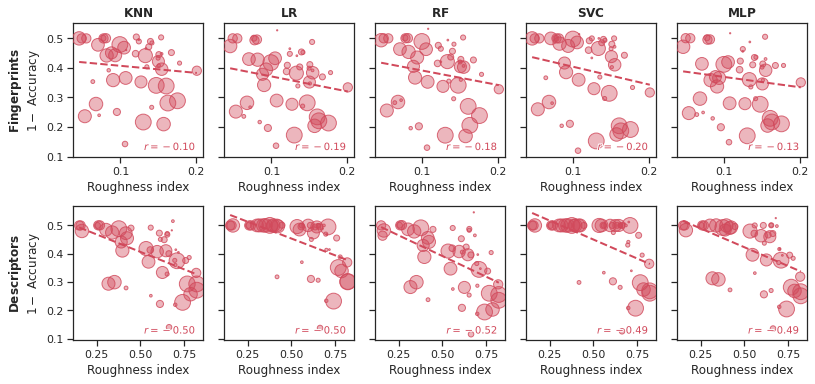

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(11.5, 5.5), sharey='row', sharex='row')
colors = ['#DF9216','#d1495b','#00798c']

#metric = 'test_accuracy'
metric = 'test_balanced_accuracy'

x_text = 0.95
y_text = 0.05

tdc_names = RESULTS['TDC']['FPS'].keys()

# FINGERPRINTS
scores = [RESULTS['TDC']['FPS'][p]['rogi'] for p in tdc_names]
sizes = [RESULTS['TDC']['FPS'][p]['size'] for p in tdc_names]
for i, m in enumerate(models.keys()):
    accuracy = 1. - np.array([np.mean(RESULTS['TDC']['FPS'][p][m][metric]) for p in tdc_names])
    plot_scatter(axes[0,i], scores, accuracy, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], # size 50 = 2000 instances
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=x_text, y_text=y_text, fontsize=10,
                 zorder_scatter=5, label='')

# DESCRIPTORS
scores = [RESULTS['TDC']['DESC'][p]['rogi'] for p in tdc_names]
sizes = [RESULTS['TDC']['DESC'][p]['size'] for p in tdc_names]
for i, m in enumerate(models.keys()):
    accuracy = 1. - np.array([np.mean(RESULTS['TDC']['DESC'][p][m][metric]) for p in tdc_names])
    plot_scatter(axes[1,i], scores, accuracy, title='', marker='o', s=[50 * s/2000 for s in sizes], # size 50 = 2000 instances
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=x_text, y_text=y_text, fontsize=10,
                 zorder_scatter=5, label='')

# Fix labels, ticks, etc.
axes[0,0].set_ylabel('$\\bf{Fingerprints}$\n$1 -$ Accuracy')
axes[1,0].set_ylabel('$\\bf{Descriptors}$\n$1 -$ Accuracy')

for j in range(5):
    axes[0,j].set_xlabel('Roughness index')
    axes[1,j].set_xlabel('Roughness index')
    
plt.tight_layout()
fig.savefig(f'plots/classification-rogi-{metric}.png', dpi=600, bbox_inches='tight')
fig.savefig(f'plots/classification-rogi-{metric}.pdf', bbox_inches='tight')

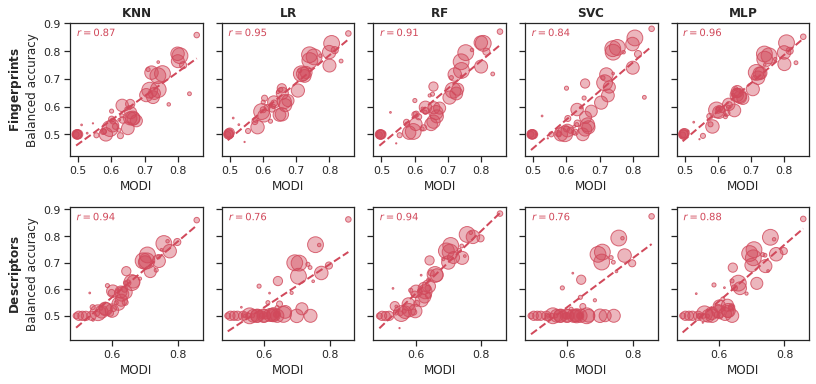

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(11.5, 5.5), sharey='row', sharex='row')
colors = ['#DF9216','#d1495b','#00798c']

#metric = 'test_accuracy'
metric = 'test_balanced_accuracy'

x_text = 0.35
y_text = 0.9

tdc_names = RESULTS['TDC']['FPS'].keys()

# FINGERPRINTS
scores = [RESULTS['TDC']['FPS'][p]['modi'] for p in tdc_names]
sizes = [RESULTS['TDC']['FPS'][p]['size'] for p in tdc_names]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS['TDC']['FPS'][p][m][metric]) for p in tdc_names])
    plot_scatter(axes[0,i], scores, accuracy, title=f'$\\bf{m}$', marker='o', s=[50 * s/2000 for s in sizes], # size 50 = 2000 instances
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=x_text, y_text=y_text, fontsize=10,
                 zorder_scatter=5, label='')

# DESCRIPTORS
scores = [RESULTS['TDC']['DESC'][p]['modi'] for p in tdc_names]
sizes = [RESULTS['TDC']['DESC'][p]['size'] for p in tdc_names]
for i, m in enumerate(models.keys()):
    accuracy = np.array([np.mean(RESULTS['TDC']['DESC'][p][m][metric]) for p in tdc_names])
    plot_scatter(axes[1,i], scores, accuracy, title='', marker='o', s=[50 * s/2000 for s in sizes], # size 50 = 2000 instances
                 fit=True, fit_outline=False, fit_zorder=0, fit_lw=2,
                 color=colors[1], edgecolor=colors[1], linewidth=1, alpha_face=0.4, alpha_edge=0.8,
                 annotate=True, text_color=colors[1], x_text=x_text, y_text=y_text, fontsize=10,
                 zorder_scatter=5, label='')

# Fix labels, ticks, etc.
axes[0,0].set_ylabel('$\\bf{Fingerprints}$\nBalanced accuracy')
axes[1,0].set_ylabel('$\\bf{Descriptors}$\nBalanced accuracy')

for j in range(5):
    axes[0,j].set_xlabel('MODI')
    axes[1,j].set_xlabel('MODI')
    
plt.tight_layout()
fig.savefig(f'plots/classification-modi-{metric}.png', dpi=600, bbox_inches='tight')
fig.savefig(f'plots/classification-modi-{metric}.pdf', bbox_inches='tight')